En esta práctica guiada vamos a llevar a cabo una regresión logística para predecir, en función de un conjunto de variables, si un usuario pulsará sobre un anuncio en una web o no (decisión binaria). Para ello, usaremos el dataset advertising.csv. El dataset contiene los campos a continuación:

*   Daily Time Spent on Site': tiempo en el sitio web en minutos
*   Age': edad del usuario
*   Area Income': Ingresos medios en el área del usuario
*   Daily Internet Usage': Media en minutos del usuario en Internet
*   Ad Topic Line': Cabecera del anuncio
*   City': Ciudad de origen del usuario
*   Male': Sexo (0: mujer, 1: hombre)
*   Country': País del usuario
*   Timestamp': Hora en que se cliqueó el anuncio o se abandonó la página
*   Clicked on Ad': 0 o 1 indicando si se cliqueó el anuncio.

Cabe resaltar que se trata de un sitio web de sistemas informáticos y los anuncios eran de este tipo.

Comenzaremos cargando las librerías necesarias y el dataset

In [1]:
# Importar las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from statsmodels.tools import add_constant
import statsmodels.api as sm

# Cargar el dataset
url = 'https://raw.githubusercontent.com/crisurdiales/DataMining4SmartCities/main/advertising.csv'
df = pd.read_csv(url)

# Verificar la estructura del dataset
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Daily Time Spent on Site  1000 non-null   float64
 1   Age                       1000 non-null   int64  
 2   Area Income               1000 non-null   float64
 3   Daily Internet Usage      1000 non-null   float64
 4   Ad Topic Line             1000 non-null   object 
 5   City                      1000 non-null   object 
 6   Male                      1000 non-null   int64  
 7   Country                   1000 non-null   object 
 8   Timestamp                 1000 non-null   object 
 9   Clicked on Ad             1000 non-null   int64  
dtypes: float64(3), int64(3), object(4)
memory usage: 78.2+ KB
None


Podemos observar que hay varias columnas de tipo object, esto es, variables categóricas. Antes de proceder, vamos a codificar la marca de tiempo en numérico. En concreto, nos vamos a quedar únicamente con la hora, el día y el mes, que es lo que puede resultar más relacionado con la variable dependiente. El resto lo descartamos.

In [2]:
# Convertir la columna Timestamp a formato datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Extraer la hora, el día y el mes
df['Hour'] = df['Timestamp'].dt.hour
df['Day'] = df['Timestamp'].dt.day
df['Month'] = df['Timestamp'].dt.month

# Eliminar la columna Timestamp ya que no la necesitaremos más
df.drop(columns=['Timestamp'], inplace=True)

# Verificar la estructura del dataset
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Daily Time Spent on Site  1000 non-null   float64
 1   Age                       1000 non-null   int64  
 2   Area Income               1000 non-null   float64
 3   Daily Internet Usage      1000 non-null   float64
 4   Ad Topic Line             1000 non-null   object 
 5   City                      1000 non-null   object 
 6   Male                      1000 non-null   int64  
 7   Country                   1000 non-null   object 
 8   Clicked on Ad             1000 non-null   int64  
 9   Hour                      1000 non-null   int32  
 10  Day                       1000 non-null   int32  
 11  Month                     1000 non-null   int32  
dtypes: float64(3), int32(3), int64(3), object(3)
memory usage: 82.2+ KB
None


Con las columnas objeto restantes probaremos dos métodos distintos de codificación para comparar los resultados: Label Encoding, esto es a cada etiqueta distinta que aparezca se le asigna un numero en orden ascendente, y 1-hot encoding, es decir, cada variable categorica se descompone en tantas columnas como valores pueda tomar y en cada fila se pone la columna correspondiente a 1 y el resto a 0. Esto último genera muchas columnas, pero se evita introducir un orden o relaciones jerárquicas entre los valores.

   Daily Time Spent on Site  Age  Area Income  Daily Internet Usage  Male  \
0                     68.95   35     61833.90                256.09     0   
1                     80.23   31     68441.85                193.77     1   
2                     69.47   26     59785.94                236.50     0   
3                     74.15   29     54806.18                245.89     1   
4                     68.37   35     73889.99                225.58     0   

   Clicked on Ad  Hour  Day  Month  \
0              0     0   27      3   
1              0     1    4      4   
2              0    20   13      3   
3              0     2   10      1   
4              0     3    3      6   

   Ad Topic Line_Adaptive 24hour Graphic Interface  ...  Country_Uruguay  \
0                                            False  ...            False   
1                                            False  ...            False   
2                                            False  ...            False   
3   

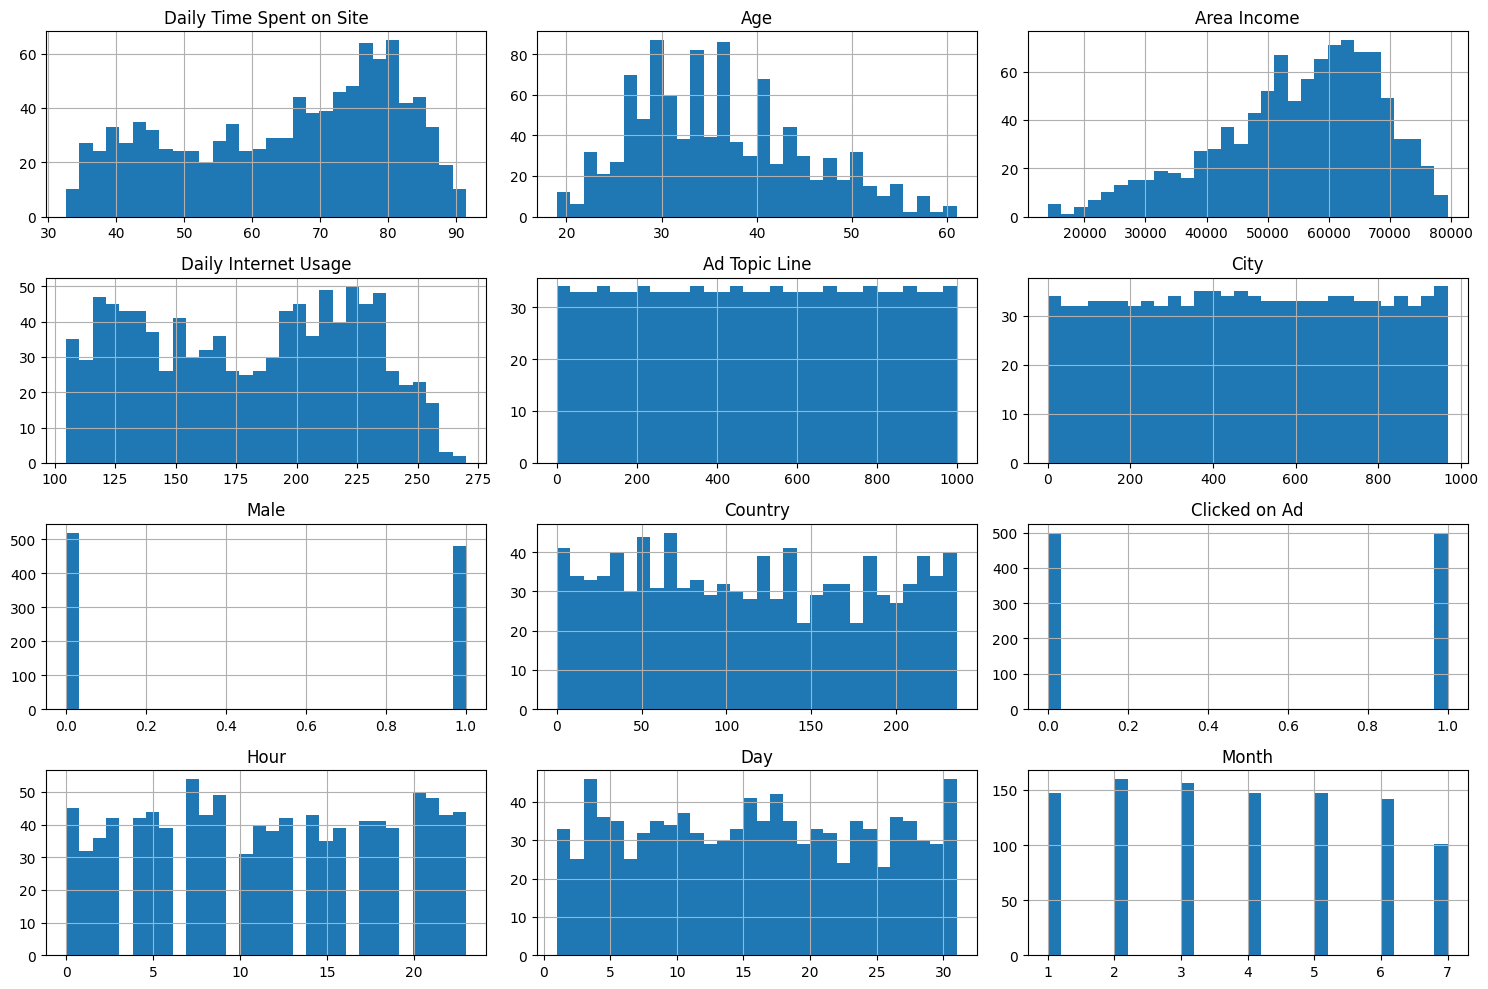

In [3]:
# Convertir las columnas categóricas a numéricas

#1-hot encoding
# Convertir las columnas categóricas a variables dummy (One-Hot Encoding)
df1hot = pd.get_dummies(df, columns=['Ad Topic Line', 'City', 'Country'])

# Verificar las primeras filas del DataFrame modificado
print(df1hot.head())

#Label encoding
df['Ad Topic Line'] = df['Ad Topic Line'].astype('category').cat.codes
df['City'] = df['City'].astype('category').cat.codes
df['Country'] = df['Country'].astype('category').cat.codes

# Exploración de los datos en Label Encoding
df.hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()

Ahora que todos los datos son numéricos, en el caso del Label Encoding podemos calcular la correlación de las variables dos a dos. Por ejemplo, se puede observar que hay una correlación fuerte entre el tiempo que una persona pasa en el sitio web y la probablidad de pulsar sobre el anuncio, así como entre el uso diario de internet y dicha pulsación. Hay una correlación menor, pero visible, con la edad y los ingresos del usuario. Cabe indicar también que hay muy baja correlación entre la variable dependiente y las de la marca de tiempo.

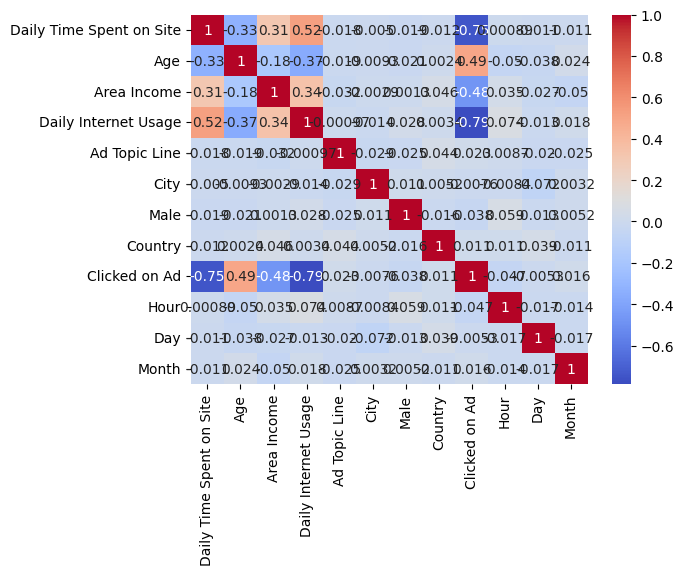

In [4]:
# Ver correlaciones
corr = df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

Para la regresión logística con Label Encoding, podemos limitarnos a las variables independientes que parecen estar relacionadas con la dependiente, esto es, las cuatro ya mencionadas arriba.

Puede observarse una correlación moderada entre Daily Internet Usage y Daily Time Spent on Site, pero para este ejercicio no vamos a tenerla en cuenta.

In [5]:
# Seleccionar características significativas
features = ['Daily Time Spent on Site', 'Age', 'Area Income', 'Daily Internet Usage']
X = df[features]
y = df['Clicked on Ad']


Estos datos ya pueden dividirse en entrenamiento y prueba para obtener el modelo deseado.

In [7]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# Ajustar el modelo de regresión logística en el conjunto de entrenamiento
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Evaluar el modelo en el conjunto de prueba
y_pred = model.predict(X_test)

# Imprimir la matriz de confusión y el informe de clasificación
print("Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred))
print("\nInforme de Clasificación:")
print(classification_report(y_test, y_pred))

Matriz de Confusión:
[[139   7]
 [ 28 126]]

Informe de Clasificación:
              precision    recall  f1-score   support

           0       0.83      0.95      0.89       146
           1       0.95      0.82      0.88       154

    accuracy                           0.88       300
   macro avg       0.89      0.89      0.88       300
weighted avg       0.89      0.88      0.88       300



Por otro lado, también vamos a calcular el modelo con las columnas objeto codificadas en 1-hot para comparar con el modelo Label Encoding, donde, recordemos, finalmente, sólo nos quedamos 4 variables independientes, ninguna de las cuales era tipo objeto. El objetivo de esta comprobación es ver si la poca correlación de las variables objeto con la variable dependiente era el resultado del Label Encoding y, con otra codificación más apropiada, pueden aportar a los resultados o no.

In [8]:
from sklearn.preprocessing import StandardScaler

# Separar las características (X) y el objetivo (y)

X1hot = df1hot.drop(columns=['Clicked on Ad'])
y1hot = df1hot['Clicked on Ad']

# Dividir los datos en conjuntos de entrenamiento y prueba
X1hot_train, X1hot_test, y1hot_train, y1hot_test = train_test_split(X1hot, y1hot, test_size=0.3, random_state=1)

#Normalizacion
scaler = StandardScaler()
X1hot_train_scaled = scaler.fit_transform(X1hot_train)
X1hot_test_scaled = scaler.transform(X1hot_test)


In [9]:
# Ajustar el modelo de regresión logística en el conjunto de entrenamiento
model1hot = LogisticRegression(max_iter=1000)
model1hot.fit(X1hot_train_scaled, y1hot_train)

# Evaluar el modelo en el conjunto de prueba
y1hot_pred = model1hot.predict(X1hot_test_scaled)

# Imprimir la matriz de confusión y el informe de clasificación
print("Matriz de Confusión:")
print(confusion_matrix(y1hot_test, y1hot_pred))
print("\nInforme de Clasificación:")
print(classification_report(y1hot_test, y1hot_pred))

Matriz de Confusión:
[[144   2]
 [ 26 128]]

Informe de Clasificación:
              precision    recall  f1-score   support

           0       0.85      0.99      0.91       146
           1       0.98      0.83      0.90       154

    accuracy                           0.91       300
   macro avg       0.92      0.91      0.91       300
weighted avg       0.92      0.91      0.91       300



Como se puede apreciar, no hay gran diferencia en los resultados, por lo que, independientemente de la codificación, las variables independientes con baja correlación con la dependiente no aportan mejora significativa. Por tanto, en adelante seguimos analizando sólo el modelo más sencillo.



Podemos observar en la curva ROC para el primer modelo un valor de área de .88, lo que indica que el modelo es capaz de distinguir entre las clases positivas y negativas con un alto grado de precisión.



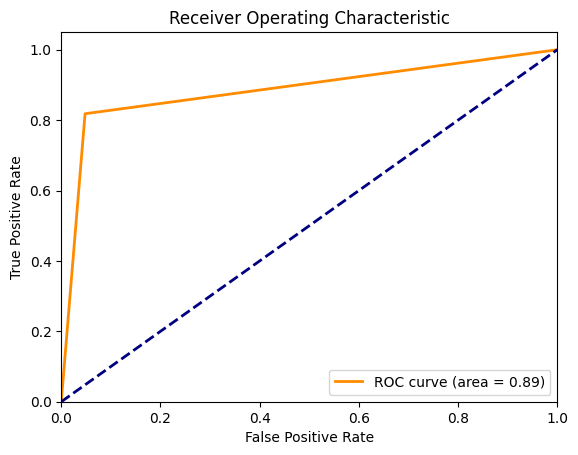

In [11]:
# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


A continuación, podemos ver los pesos relativos de las variables de entrada sobre la predicción. Los pesos negativos indican que si la variable se incrementa, la probabilidad de un 1 a la salida baja. Por ejemplo, si se incrementa el tiempo en un sitio web, la probabilidad de pulsar sobre el anuncio se reduce. Por contra, a más edad del usuario, más probabilidad en este modelo de pulsar sobre el anuncio.

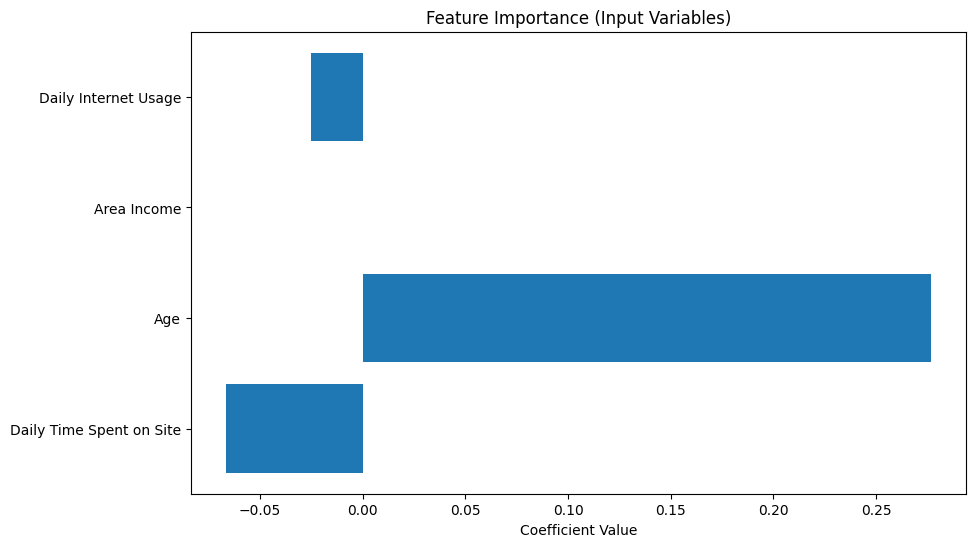

In [12]:
# Obtener los coeficientes del modelo
coefficients = model.coef_[0]

# Obtener los nombres de las características
feature_names = X.columns

# Crear un DataFrame para visualizar los coeficientes
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})


# Filtrar solo las características de entrada (excluyendo las generadas por one-hot encoding)
input_features = coef_df[~coef_df['Feature'].str.startswith('Ad Topic Line') &
                         ~coef_df['Feature'].str.startswith('City') &
                         ~coef_df['Feature'].str.startswith('Country')]

# Visualizar la importancia de las variables de entrada
plt.figure(figsize=(10, 6))
plt.barh(input_features['Feature'], input_features['Coefficient'])
plt.xlabel('Coefficient Value')
plt.title('Feature Importance (Input Variables)')
plt.show()


Finalmente, podemos probar el modelo para predecir cualquier situación. Por ejemplo, un usuario de 25 años, tras 65 minutos en el sitio web, con una media de 120 minutos diarios en Internet en un area de salarios relativamente bajos (la moda de la distribución está en 65k) se prevé que no pulsará en el anuncio. No obstante, de acuerdo a los pesos del modelo, el resultado no cambiaría si se trata de un área con mucho mayor poder adquisitivo.

In [ ]:
input_data = pd.DataFrame({'Daily Time Spent on Site': [65], 'Age': [25], 'Area Income': [15000], 'Daily Internet Usage': [120]})
input_data.columns = X_train.columns
y_pred = model.predict(input_data)

print('Predicción:', y_pred)

Predicción: [0]
